<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/Simulation/HeierTurbineModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.ticker as ticker

In [16]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

Turbine model taken from

S. Heier, *Grid Integration of Wind Energy*, 3th Edition, Wiley

In [18]:
def C_P( Λ, β, c ):
    Λi = 1.0 / ( 1.0 / ( Λ + c[8] * β ) - c[9] / ( β**3 + 1 ) ) 
    cp = c[1] * ( c[2] / Λi - c[3] * β - c[4] * Λ**c[5] - c[6] ) * np.exp( -c[7] / Λi )
    return cp

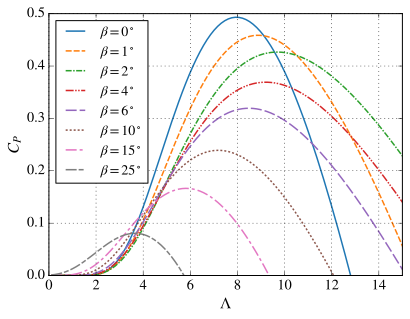

In [19]:
#                c_1   c_2  c_3   c_4    c_5    c_6   c_7    c_8    c_9      
c_Heier = ( 0.0, 0.50, 116, 0.40, 0.000, 0.00,  5.00, 21.0,  0.08,  0.035 )
c_H0    = ( 0.0, 0.60, 116, 0.40, 0.000, 1.50,  5.00, 21.0,  0.08,  0.035 )
c_CST   = ( 0.0, 0.44, 125, 0.00, 0.000, 0.00,  6.94, 16.5,  0.00, -0.002 )
c_VST   = ( 0.0, 0.73, 151, 0.58, 0.002, 2.14, 13.20, 18.4, -0.02, -0.003 )

Λ_vec = np.linspace( 0.1, 30, 200 )
c_vec = c_H0
β_vec = ( 0, 1, 2, 4, 6, 10, 15, 25 )

for β in β_vec:
  mpl.plot( Λ_vec, C_P( Λ_vec, β, c_vec ), label='$\\beta=%.0f^\circ$' % β )

mpl.legend( loc='upper left', fontsize=14 )
mpl.grid()
mpl.xlim( 0, 15 )
mpl.ylim( 0, 0.5 )
mpl.xlabel( '$\Lambda$' )
mpl.ylabel( '$C_P$' )
mpl.savefig( 'HeierTurbine.pdf', bbox_inches='tight', pad_inches=0.02 );

In [21]:
Λ_max = Λ_vec[ np.argmax( C_P( Λ_vec, 0, c_vec ) ) ]
CP_max = np.max( C_P( Λ_vec, 0, c_vec ) )

Λ_max, CP_max

(7.913065326633165, 0.49311008812104135)

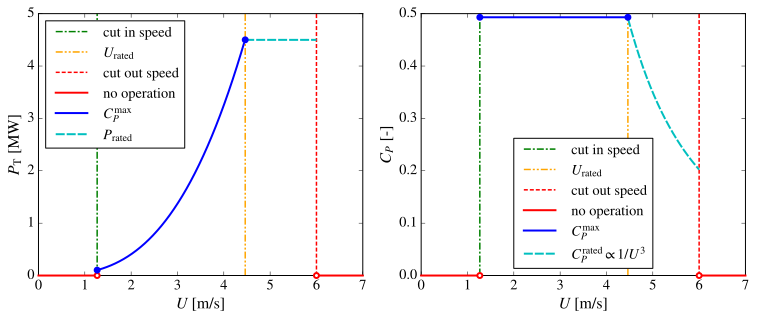

In [156]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.18 )

U = np.linspace( 0, 6, 200 )
ρ = 1025
AT = np.pi * 8.0**2
P = 0.5 * ρ * U**3 * AT * CP_max

P /= 1E6 # convert to MW

Prated = 4.5 
rated = np.argmax( P > Prated )
cut_in  = np.argmin( P < 0.1 )

U_cut_in = U[cut_in]
U_rated  = U[rated]
U_cut_out = 6.0

P[ P >= Prated ] = np.nan
P[ P < 0.1 ] = np.nan


ax1.axvline( U_cut_in, dashes=(7,2,2,2), color='g', lw=1.5, label='cut in speed' )
ax1.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#FFA500', lw=1.5, label='$U_\mathrm{rated}$' )
ax1.axvline( U_cut_out, dashes=(4,2), color='r', lw=1.5, label='cut out speed' )

ax1.plot( (0,U_cut_in), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4 )
ax1.plot( (U_cut_in), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax1.plot( (U_cut_out,7), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4, label='no operation' )
ax1.plot( (U_cut_out), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax1.plot( U, P, 'b-', lw=2, clip_on=False, zorder=4, label='$C_P^\mathrm{max}$' )
ax1.plot( (U_cut_in,U_rated), (P[cut_in],Prated), 'bo', markeredgewidth=2, markeredgecolor='b', lw=2, zorder=4 )

ax1.set_axisbelow(True)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1) )
ax1.plot( (U_rated,6), (Prated,Prated), lw = 2, dashes=(9,2), color='c', label='$P_\mathrm{rated}$' )

Uo = np.linspace( U_rated, 6, 20 )
CPo = Prated * 1E6 / ( 0.5 * ρ * Uo**3 * AT )

ax1.set_xlim( 0,7 )
ax1.legend( loc='upper left', handlelength=2.8 )
ax1.set_xlabel( '$U$ [m/s]' )
ax1.set_ylabel( '$P_\mathrm{T}$ [MW]' )


ax2.set_axisbelow(True)
ax2.set_xlim( 0,7 )
ax2.axvline( U_cut_in, dashes=(7,2,2,2), color='g', lw=1.5, label='cut in speed' )
ax2.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#FFA500', lw=1.5, label='$U_\mathrm{rated}$' )
ax2.axvline( U_cut_out, dashes=(4,2), color='r', lw=1.5, label='cut out speed' )

ax2.plot( (0,U_cut_in), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4, label='no operation' )
ax2.plot( (U_cut_in), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax2.plot( (U_cut_out,7), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4 )
ax2.plot( (U_cut_out), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax2.plot( (U_cut_in, U_rated), (CP_max,CP_max ), 'b-', lw=2, label='$C_P^\mathrm{max}$' )
ax2.plot( (U_cut_in, U_rated), (CP_max,CP_max ), 'bo', markeredgewidth=2, markeredgecolor='b', lw=2, zorder=4 )

ax2.plot( Uo, CPo, lw = 2, dashes=(9,2), color='c', label='$C_P^\mathrm{rated}\propto 1/U^3$' )

ax2.legend( loc='lower center', handlelength=2.8 )
ax2.set_xlabel( '$U$ [m/s]' )
ax2.set_ylabel( '$C_P$ [-]' )

mpl.savefig( 'TurbineOperation.pdf', bbox_inches='tight', pad_inches=0.02 );

In [69]:
U_cut_in

(1.2663316582914572,)